This notebook is a replica of *Notebook 2--Inverse-design*, except that it modifies the `TDwgNet` function to have a mismatched forward- and backward pass to emulate the imperfections of real experiments. Any design notebooks in this repository using inverse-desing can be modified to do the same by replacing the `TDwgNet` function with the one presented in this notebook.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
import tdwg_lib.ftutils_torch as ftutils
from tdwg_lib.split_step_solver import BPMSplitStepSolver
from tdwg_lib.waveguide import Waveguide
from tdwg_lib.beam_utils import gaussian_beam, make_HG_modes
from tdwg_lib.helpers import smoothen2d, timestring
from tdwg_lib.pat import make_pat_func
from tdwg_lib.pnn_utils import L2, has_converged
from tdwg_lib import pnn_utils 

## Parameters

In [3]:
NMODES = 2  # Number of input/output modes

# Waveguide parameters
LAMBDA0 = 1.55  # Free-space wavelength in μm
K0 = 2*np.pi/LAMBDA0  # Free-space wavenumber in μm⁻¹
NEFF = 1.8  # Effective refractive index of slab mode

# Transverse (x) axis
LX = 500  # Width of simulation area in μm
NX = 2**9  # Number of grid points in transverse dimension
DX = LX/(NX-1)  # Grid spacing in transverse dimension in μm
X_AXIS = ftutils.ft_t_axis(NX, DX)  # Centered frequency-domain axis

# Propagation (z) axis
DZ = 50  # Propagation step size in μm
LZ = 10000  # Total propagation length in μm
NZ = int(np.floor(LZ/DZ))  # Number of propagation steps
Z_AXIS = (torch.arange(NZ)+1)*DZ  # Propagation coordinate starting at DZ

# Mode properties
MODE_X_MIN = -50 * (NMODES-1)  # Center position of leftmost input mode in μm
MODE_X_MAX = 50 * (NMODES-1)  # Center position of rightmost input mode in μm
W0 = 20  # Beam waist (1/e² radius) in μm

# Training parameters
DELTA_N_VAL = 1e-3  # Maximum refractive index change
ITERATIONS = 100  # Number of training epochs
LR = 0.5e-1  # Learning rate for optimizer
GAMMA = 0.99  # Learning rate decay factor
BATCH_SIZE = NMODES  # Batch size for training
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Waveguide container object stores simulation geometry and parameters
wg = Waveguide(NEFF, X_AXIS, Z_AXIS, device=DEVICE)

## Create trainable 2D waveguide class as pytorch.nn.Module 

### New here: Separate forward- and backward-pass functions

The `TDwgNet` class has separate `forward_internal` and `backward_internal` functions, which are fused into a single function `f_pat`, which calls the correct function on the forward/backward pass. 

The `forward_internal` function could be replaced with code that calls an experiment instead.
To emulate the imperfections of real experimental setups, we have added an artificial misalignment of the inputs in the `forward_internal` function.

In [ ]:
class TDwgNet(nn.Module):
    def __init__(self, solver, wg, delta_n_val, input_modes, output_modes, device, mode='insilico', res_x=6, res_z=6):
        super(TDwgNet, self).__init__()
        self.device = device
        
        # Initialize trainable modulation parameter with bounds [0.05, 0.95]
        mod = 0.5*torch.ones([wg.Nz, wg.Nx], requires_grad=True, dtype=torch.float32).to(self.device)
        self.mod = pnn_utils.Parameter(mod, limits=[0.05, 0.95])
        
        self.delta_n_val = delta_n_val  # Maximum refractive index change
        self.scale_x = res_x  # Resolution limit in x-direction (smoothing scale)
        self.scale_z = res_z  # Resolution limit in z-direction (smoothing scale)
        
        self.input_modes = input_modes.to(dtype=torch.complex64).to(self.device)
        self.output_modes = output_modes.to(dtype=torch.complex64).to(self.device)
        
        self.wg = wg
        self.solver = solver
        
        # Set up physics-aware training (PAT) if mode='pat', otherwise use standard forward
        if mode == 'pat': 
            self.f_pat = make_pat_func(self.forward_internal, self.backward_internal)
        if mode == 'insilico': 
            self.f_pat = self.forward_internal

    def forward(self, x):
        # Main forward pass: calls either PAT or standard forward
        a_out = self.f_pat(x, self.mod)
        return a_out

    def forward_internal(self, x, mod, monitor=False):
        """Forward pass with experimental imperfections (e.g., misaligned inputs)."""
        # Clip modulation to valid range and apply smoothing filter to emulate finite resolution
        mod = self.mod.clip(0., 1.)
        mod = smoothen2d(self.wg.x_axis, self.wg.z_axis, mod, scale_x=self.scale_x, scale_z=self.scale_z)

        # Apply artificial misalignment to input modes to emulate experimental imperfections
        input_modes_misaligned = torch.roll(self.input_modes, INDS_MISALIGNMENT, dims=-1)
        inputs = x.to(self.device) @ input_modes_misaligned
        
        # Compute refractive index distribution (could add unmodeled inhomogeneities here)
        delta_n = self.wg.background_delta_n + self.delta_n_val*mod
        
        # Propagate through waveguide
        output_beams = self.solver.run_simulation(inputs, delta_n, monitor)
        
        # Project output fields onto output mode basis (overlap integral with dx scaling)
        a_out = output_beams @ self.output_modes.T * self.wg.dx
        return a_out
        
    def backward_internal(self, x, mod):
        # Clip modulation to valid range and apply smoothing filter to emulate finite resolution
        mod = self.mod.clip(0., 1.)
        mod = smoothen2d(self.wg.x_axis, self.wg.z_axis, mod, scale_x=self.scale_x, scale_z=self.scale_z)

        # Use ideal (non-misaligned) input modes for gradient calculation
        inputs = x.to(self.device) @ self.input_modes
        
        # Compute refractive index distribution
        delta_n = self.wg.background_delta_n + self.delta_n_val*mod
        
        # Propagate through waveguide
        output_beams = self.solver.run_simulation(inputs, delta_n)
        
        # Project output fields onto output mode basis (overlap integral with dx scaling)
        a_out = output_beams @ self.output_modes.T * self.wg.dx
        return a_out

## Define input and output modes

In [5]:
INPUT_MISALIGNMENT = 5  # Transverse misalignment of inputs in μm
# Play around with this value to see whether the training algorithm can handle the misalignment
# A misalignment of 20 μm does not work well anymore

In [6]:
# Input modes: Gaussian beams evenly spaced from MODE_X_MIN to MODE_X_MAX
INPUT_MODES = torch.vstack([gaussian_beam(X_AXIS, mu, W0) for mu in np.linspace(MODE_X_MIN, MODE_X_MAX, NMODES)])

# Output modes: Hermite-Gauss modes centered at x=0
OUTPUT_MODES = make_HG_modes(X_AXIS, x_center=0, w0=W0, n=NMODES)

In [7]:
# Calculate misalignment in grid indices
INDS_MISALIGNMENT = wg.x2ind(INPUT_MISALIGNMENT) - wg.x2ind(0)

# Create misaligned input modes for visualization
input_modes_misaligned = torch.roll(INPUT_MODES, INDS_MISALIGNMENT, dims=-1)

/home/mms266/.conda/envs/2Dwg/lib/python3.12/site-packages/torch/_tensor.py:1151: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/home/mms266/.conda/envs/2Dwg/lib/python3.12/site-packages/matplotlib/axes/_axes.py:5484: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[1:N+1, 1] = dep1slice
/home/mms266/.conda/envs/2Dwg/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


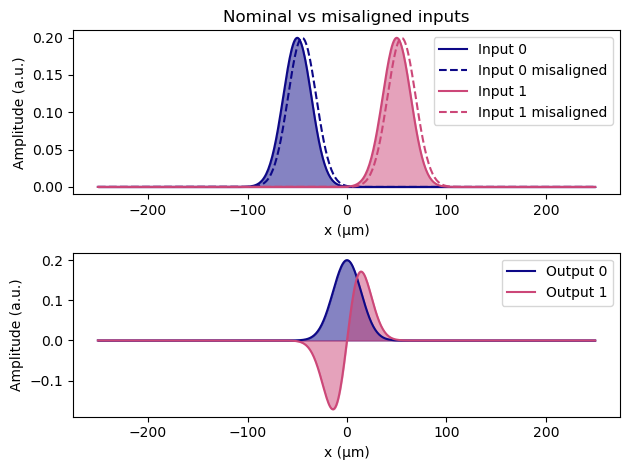

In [8]:
# Plot nominal vs misaligned input modes
plt.subplot(2, 1, 1)
for ind_mode, mode in enumerate(INPUT_MODES):
    plt.plot(X_AXIS, INPUT_MODES[ind_mode].cpu(), color=cm.plasma(ind_mode/NMODES), label=f"Input {ind_mode}")
    plt.fill_between(X_AXIS, mode, color=cm.plasma(ind_mode/NMODES), alpha=0.5)
    plt.plot(X_AXIS, input_modes_misaligned[ind_mode].cpu(), color=cm.plasma(ind_mode/NMODES), ls='--', label=f"Input {ind_mode} misaligned")

plt.legend(loc='upper right')
plt.xlabel('x (μm)')
plt.title('Nominal vs misaligned inputs')
plt.ylabel('Amplitude (a.u.)')

# Plot output modes
plt.subplot(2, 1, 2)
for ind_mode, mode in enumerate(OUTPUT_MODES):
    plt.fill_between(X_AXIS, mode.real, color=cm.plasma(ind_mode/NMODES), alpha=0.5)
    plt.plot(X_AXIS, mode.real, color=cm.plasma(ind_mode/NMODES), label=f'Output {ind_mode}')

plt.legend(loc='upper right')
plt.xlabel('x (μm)')
plt.ylabel('Amplitude (a.u.)')

plt.tight_layout()

In [9]:
# Define target unitary transformation: identity matrix maps each input to corresponding output
# (input 0 → output 0, input 1 → output 1, etc.)
U_TARGET = torch.eye(NMODES, dtype=torch.complex64, device=DEVICE)

## Training loop

In [10]:
# Initialize beam propagation method solver
bpmsolver = BPMSplitStepSolver(X_AXIS, Z_AXIS, NEFF)

# Create 2D-waveguide object with trainable index modulation (mode='pat' enables physics-aware training)
tdwg_pnn = TDwgNet(bpmsolver, wg, DELTA_N_VAL, INPUT_MODES, OUTPUT_MODES, DEVICE, mode='pat')

# Setup Adam optimizer
optimizer = optim.Adam(tdwg_pnn.parameters(), lr=LR)

# Setup learning rate scheduler with exponential decay
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

# Set model to training mode
tdwg_pnn.train()

TDwgNet()

In [11]:
PRINT_INTERVAL = 10  # Print loss every N iterations

loss_list = []
n = len(tdwg_pnn.input_modes)  # Number of modes
indices = np.arange(n)  # Create array of mode indices
# Split indices into batches for mini-batch training
batch_indices = np.array_split(indices, np.ceil(n / BATCH_SIZE))

for i in range(ITERATIONS):
    optimizer.zero_grad()  # Reset gradients

    # Loop over batches
    for indices in batch_indices:
        # Forward pass: compute numerical unitary for this batch
        U_num = tdwg_pnn.forward(torch.eye(n, dtype=torch.complex64)[indices])
        
        # Objective loss: L2 distance between numerical and target unitary
        l_objective = L2(U_TARGET[indices], U_num)

        # Lagrangian penalty: enforce parameter bounds (limiting largest refractive index change)
        l_lagrange = pnn_utils.lagrangian(tdwg_pnn, lag_amp=1, factor=20)
        
        # Total loss
        l = l_objective + l_lagrange
        l.backward()  # Compute gradients
        
    optimizer.step()  # Update parameters
    scheduler.step()  # Decay learning rate
    loss_list.append(l.detach().cpu().data)

    # Print progress
    if i % PRINT_INTERVAL == 0:
        print(timestring() + f"--Iteration: {i}, Loss: {l.detach().cpu().data:.5f}")
    # Early stopping commented out for demonstration
    # if has_converged(loss_list):
    #     print(timestring() + f"Converged at iteration: {i}, Loss: {l.detach().cpu().data:.5f}")
    #     break

/vast/palmer/home.grace/mms266/2D-waveguide-demo-code/tdwg_lib/split_step_solver.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dz = torch.tensor(self.dz, device=device, dtype=delta_n.dtype)


2025-10-04--15-41-54--Iteration: 0, Loss: 0.47060
2025-10-04--15-41-55--Iteration: 10, Loss: 0.05685
2025-10-04--15-41-56--Iteration: 20, Loss: 0.02641
2025-10-04--15-41-57--Iteration: 30, Loss: 0.00490
2025-10-04--15-41-58--Iteration: 40, Loss: 0.00329
2025-10-04--15-41-59--Iteration: 50, Loss: 0.00160
2025-10-04--15-42-00--Iteration: 60, Loss: 0.00140
2025-10-04--15-42-01--Iteration: 70, Loss: 0.00110
2025-10-04--15-42-02--Iteration: 80, Loss: 0.00103
2025-10-04--15-42-03--Iteration: 90, Loss: 0.00102


Text(0, 0.5, 'Loss')

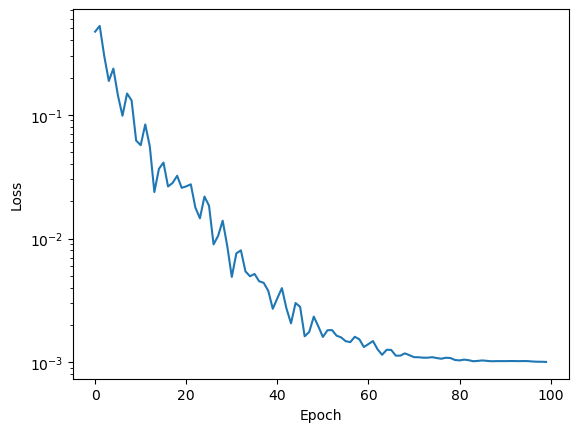

In [12]:
# Plot training loss history
plt.plot(loss_list)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [13]:
# Perform forward pass with monitor=True to store internal optical fields for visualization
with torch.no_grad():
    U_num_inv = tdwg_pnn.forward_internal(torch.eye(NMODES, dtype=torch.complex64), tdwg_pnn.mod, monitor=True)

# Compute relative error: mean absolute difference normalized by target magnitude
avg_error_inv = torch.mean(torch.abs(U_num_inv - U_TARGET)) / torch.mean(torch.abs(U_TARGET)) * 100
print(f"Average error for inverse design: {avg_error_inv:.2f}%")

Average error for inverse design: 4.14%


## Plot results

In [14]:
def plot_delta_n(z_axis, x_axis, delta_n, vmax):
    figsize_deltan = (2*3, 2*1.5*3/5)  # Figure size in inches
    fig_main, ax = plt.subplots(figsize=figsize_deltan, dpi=200)
    
    # Plot refractive index: convert z to mm, take real part, transpose for (x, z) orientation
    img = plt.pcolormesh(z_axis/1000, x_axis, np.real(delta_n.T), cmap="Greens", vmax=vmax, vmin=0)
    
    plt.ylim(x_axis.min(), x_axis.max())
    plt.xlabel("z (mm)")
    plt.ylabel("x (μm)")
    plt.title(r"$\Delta n(x, z)$")
    plt.colorbar()

    plt.show()

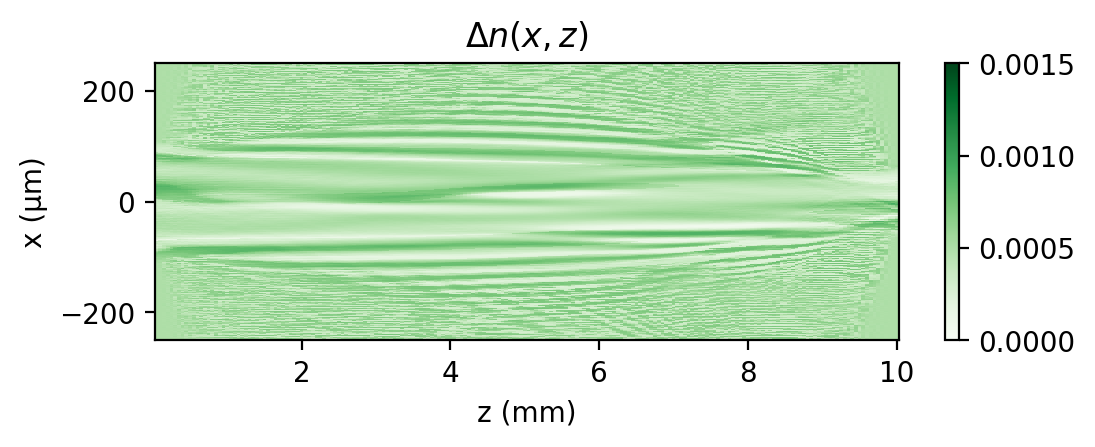

In [15]:
# Extract optimized refractive index: clip and scale trained modulation parameter
delta_n_inv = DELTA_N_VAL * (torch.clip(tdwg_pnn.mod.detach().cpu(), 0., 1.))

# Plot optimized refractive index distribution
plot_delta_n(wg.z_axis, wg.x_axis, delta_n_inv, 1.5*DELTA_N_VAL)

In [16]:
def plot_intensity(z_axis, x_axis, Imat_x):
    figsize_deltan = (2*3, 2*1.5*3/5)  # Figure size in inches
    fig_main, ax = plt.subplots(figsize=figsize_deltan, dpi=200)
    
    # Plot intensity: convert z to mm, transpose for (x, z) orientation
    img = plt.pcolormesh(z_axis/1000, x_axis, Imat_x, cmap="Reds")
    
    plt.ylim(x_axis.min(), x_axis.max())
    plt.xlabel("z (mm)")
    plt.ylabel("x (μm)")
    plt.title(r"$I(x, z)$")
    plt.colorbar()

    plt.show()

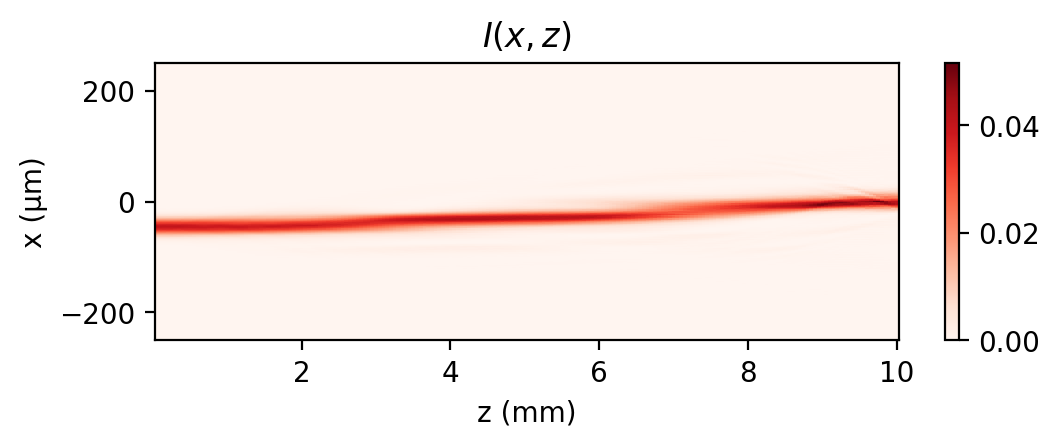

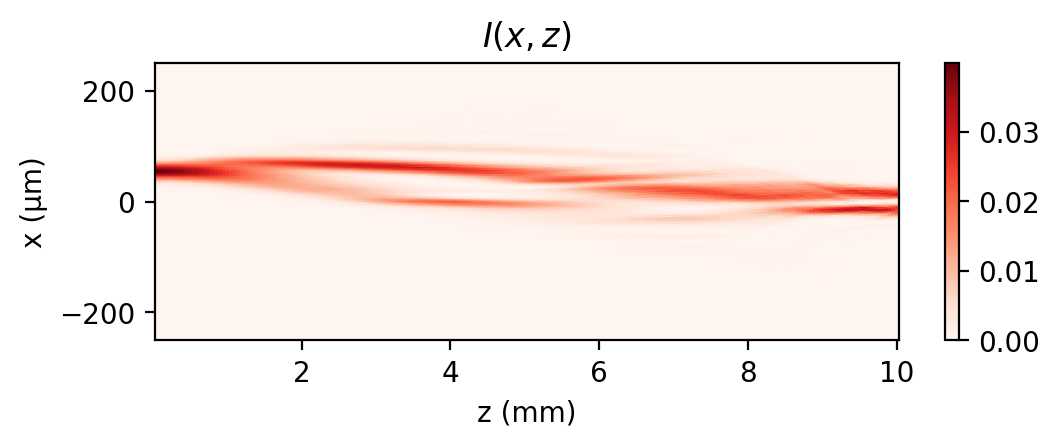

In [17]:
# Plot intensity evolution for mode 0
IND = 0
Emat_x = tdwg_pnn.solver.Emat_x[:, IND].cpu().detach()
Imat_x = Emat_x.abs().square()  # Compute intensity: |E|²
z_list = Z_AXIS[::tdwg_pnn.solver.Ncom]  # Downsample z-axis based on monitor interval
plot_intensity(z_list, X_AXIS, Imat_x.T)

# Plot intensity evolution for mode 1
IND = 1
Emat_x = tdwg_pnn.solver.Emat_x[:, IND].cpu().detach()
Imat_x = Emat_x.abs().square()  # Compute intensity: |E|²
z_list = Z_AXIS[::tdwg_pnn.solver.Ncom]  # Downsample z-axis based on monitor interval
plot_intensity(z_list, X_AXIS, Imat_x.T)

In [18]:
# Extract output field at final propagation step
Eout_x = tdwg_pnn.solver.Emat_x[-1].cpu().detach()

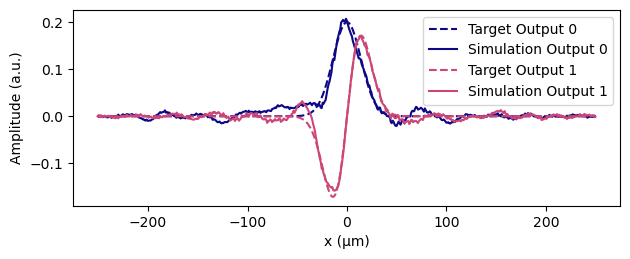

In [19]:
# Compare target output modes with achieved simulation outputs
plt.subplot(2, 1, 2)
for ind_mode, mode in enumerate(OUTPUT_MODES):
    # Plot target output modes
    plt.plot(X_AXIS, mode.real, color=cm.plasma(ind_mode/NMODES), ls='--', label=f'Target Output {ind_mode}')
    # Plot achieved simulation outputs
    plt.plot(X_AXIS, Eout_x[ind_mode].real, color=cm.plasma(ind_mode/NMODES), label=f'Simulation Output {ind_mode}')

plt.legend(loc='upper right')
plt.xlabel('x (μm)')
plt.ylabel('Amplitude (a.u.)')

plt.tight_layout()